# Model Pipeline Version 5
- load full census data
- Use Rolling Method
- Feature engineering
- Result Analysis

In [42]:
pip install us

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import calendar
from us import states

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import graphviz

## Match to Old Census tract codes

In [75]:
# merge all counties id into one
worksheet1 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/cobb_county_new_tract.xlsx', dtype=object)
worksheet2 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/DeKalb_county_new_tract.xlsx', dtype=object)
worksheet3 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/fulton_county_new_tract.xlsx', dtype=object)
worksheet4 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/gwinnet_county_new_tract.xlsx', dtype=object)
worksheet5 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/clayton_county_new_tract.xlsx', dtype=object)

tract_id_difference = pd.concat([worksheet1, worksheet2, worksheet3, worksheet4, worksheet5], ignore_index=True)
tract_id_difference[tract_id_difference.columns] = tract_id_difference[tract_id_difference.columns].astype(str)

## Fecth eviction data

In [77]:
# create a function to fill the missing month in eviction dataset

def fill_missing_months(df, date_column, tract_column):
    # Drop rows with date not in format month/day/year
    df[date_column] = pd.to_datetime(
        df[date_column], format='%m/%d/%Y', errors='coerce')
    df = df.dropna(subset=[date_column])
    df = df[[date_column, tract_column]]

    # Get the unique tracts in the DataFrame
    tracts = df[tract_column].unique()

    filled_dfs = []  # List to store filled DataFrames for each tract

    # Fill missing months for each tract individually
    for tract in tracts:
        # Filter DataFrame for the current tract
        tract_df = df[df[tract_column] == tract]

        # Check if tract_df contains valid rows
        if not tract_df.empty:
            # Get the year from the minimum and maximum dates for the tract
            min_date = tract_df[date_column].dt.date.min()
            max_date = tract_df[date_column].dt.date.max()

            # Create a DataFrame with all months in the year for the tract
            year_range = pd.date_range(start=min_date, end=max_date, freq='MS')
            all_months_df = pd.DataFrame({date_column: year_range})

            # Merge the original tract_df with the all_months_df to fill missing months
            filled_tract_df = pd.merge(
                all_months_df, tract_df, on=date_column, how='left')
            # Insert the tract ID in the filled rows
            filled_tract_df[tract_column] = filled_tract_df[tract_column].fillna(
                tract)

            filled_dfs.append(filled_tract_df)

    # Combine the filled DataFrames for all tracts
    filled_df = pd.concat(filled_dfs)
    filled_df.reset_index(drop=True, inplace=True)

    return filled_df

def get_eviction_data(url: str) -> pd.DataFrame:
  r = requests.get(url)
  json = r.json()

  df = pd.DataFrame(json[0])
  df = df.reset_index()
  df = df.rename(columns={'index': 'date'})

  for i in range(1, len(json)):
    df1 = pd.DataFrame(json[i])
    df1 = df1.reset_index()
    df1 = df1.rename(columns={'index': 'date'})
    df = pd.concat([df, df1], axis=0)

  df.reset_index(drop=True, inplace=True)
  # drop NA values
  df.dropna(axis=0, subset=['TractID'], inplace=True)
  df.drop(df[df['TractID'] == '99999999999'].index, inplace = True)

  # extract last 6 digits from Tract ID for matching Tract ID with census Tract ID
  df['Eviction_Tract'] = df['TractID'].astype(str).str[-6:]
  df['Eviction_Tract'] = df['Eviction_Tract'].str[:-2] + '.' + df['Eviction_Tract'].str[-2:]

  # remove the 0s in front
  df['Eviction_Tract'] = df['Eviction_Tract'].str.lstrip('0')
  # remove the 0s by end of integer tract id
  condition = df['Eviction_Tract'].str.endswith('00')
  df.loc[condition, 'Eviction_Tract'] = df.loc[condition, 'Eviction_Tract'].str[:-3]

  #data clean = drop unnecessary columns
  columns_to_drop = ["TractID", "_id", "updatedOn"]
  df = df.drop(columns = columns_to_drop)
  df.drop_duplicates(subset = ['date', 'Eviction_Tract'], inplace = True)
  df.reset_index(drop=True, inplace=True)

  filled_df = fill_missing_months(df, 'date', 'Eviction_Tract')
  df = filled_df.merge(df, on=['date', 'Eviction_Tract'], how='left')
  df['CountyID'] = df['CountyID'].fillna(method='ffill')

  return df

# create a function to subset the data by year
def subset_by_year(df, year):
  df = df[df['date'].dt.year == year]
  return df

In [78]:
eviction_url = 'https://atl-eviction-tracker.herokuapp.com/rest/tractbymonth'
df_eviction = get_eviction_data(eviction_url)

df_2020 = subset_by_year(df_eviction, 2020)
df_2021 = subset_by_year(df_eviction, 2021)
df_2022 = subset_by_year(df_eviction, 2022)
df_2023 = subset_by_year(df_eviction, 2023)

## Get Yearly Census Data


In [79]:
api_key = "e4f8c3090a4c3bd7eb07351bedbe1a3dc039f53d"  # put census api key here

# Get the state code
state_names = ['GA']  # put the state name here

state_codes_list = []
for i in state_names:
    exec('state_code = states.{}.fips'.format(i))
    state_codes_list.append(state_code)

state_codes_list_str = ','.join(state_codes_list)

# Get the counties
county_list = list(df_eviction.CountyID.unique())
try:
    county_list.remove(None)
except:
    county_list

county_list_str = ','.join(county_list)

In [81]:
def get_census_api_url(variables: list, year: str) -> str:
    ''' get the api url for the variables we want'''
    variables_str = ','.join(variables)
    get_url = 'https://api.census.gov/data/{}/acs/acs5/profile?get=NAME,{}&for=tract:*&in=state:{}&in=county:{}&key={}'.format(
        year, variables_str, state_codes_list_str, county_list_str, api_key)
    return(get_url)


def get_census_api_data(url: str) -> pd.DataFrame:
    '''get the census data from api url'''
    r = requests.get(url)
    json = r.json()
    dff = pd.DataFrame(json)

    # format the data frame
    dff.columns = dff.iloc[0]
    dff = dff[1:]
    dff.reset_index(drop=True, inplace=True)
    return(dff)

def match_census_data(df: pd.DataFrame, tract_match: pd.DataFrame, feature_list: list) -> pd.DataFrame:
  # match the tract code to the old tract code and add-up

  # extract last 5 digits from ACS data and replace old 'tract' column
  df['tract'] = df['tract'].astype(str).str[-6:]
  df['tract'] = df['tract'].str[:-2] + '.' + df['tract'].str[-2:]

  # remove the 0s in front
  df['tract'] = df['tract'].str.lstrip('0')
  # remove the 0s by end of integer tract id
  condition = df['tract'].str.endswith('00')
  df.loc[condition, 'tract'] = df.loc[condition, 'tract'].str[:-3]

  df = df.merge(tract_match, left_on='tract', right_on='Census_Tract')
  df = df.drop(columns = ['Census_Tract'])

  df[feature_list] = df[feature_list].astype(float)
  df = df.groupby(['Eviction_Tract', 'state', 'county'])[feature_list].sum().reset_index()

  return df

def get_yearly_census_data(year: str, df_tract_match: pd.DataFrame) -> pd.DataFrame:
    # Define the lists of variables for each category

    race_list = ['DP05_0037E', 'DP05_0038E', 'DP05_0039E',
                 'DP05_0044E', 'DP05_0052E', 'DP05_0057E']
    edu_list = ['DP02_0060E', 'DP02_0061E', 'DP02_0062E', 'DP02_0063E', 'DP02_0064E',
                'DP02_0065E', 'DP02_0066E']
    income_list = ['DP03_0052E', 'DP03_0053E', 'DP03_0054E', 'DP03_0055E',
                   'DP03_0056E', 'DP03_0057E', 'DP03_0058E', 'DP03_0059E', 'DP03_0060E', 'DP03_0061E']
    occ_list = ['DP03_0027E', 'DP03_0028E',
                'DP03_0029E', 'DP03_0030E', 'DP03_0031E']
    ind_list = ['DP03_0032E', 'DP03_0033E', 'DP03_0034E', 'DP03_0035E', 'DP03_0036E',
                'DP03_0037E', 'DP03_0038E', 'DP03_0039E', 'DP03_0040E', 'DP03_0041E',
                'DP03_0042E', 'DP03_0043E', 'DP03_0044E', 'DP03_0045E']
    worker_list = ['DP03_0047E', 'DP03_0048E', 'DP03_0049E', 'DP03_0050E']
    emp_list = ['DP03_0002E', 'DP03_0003E', 'DP03_0004E', 'DP03_0005E', 'DP03_0006E', 'DP03_0007E']
    house_list = ['DP04_0046E', 'DP04_0047E', 'DP04_0005E', 'DP04_0049E']
    sex_list = ['DP05_0002E', 'DP05_0003E']
    rent_list = ['DP04_0127E',	'DP04_0128E',	'DP04_0129E',	'DP04_0130E',	'DP04_0131E',	'DP04_0132E',	'DP04_0133E',	'DP04_0135E']
    rent_over_income_list = ['DP04_0137E',	'DP04_0138E',	'DP04_0139E',	'DP04_0140E',	'DP04_0141E',	'DP04_0142E',	'DP04_0143E']


    # Generate the URLs for each category
    url_race = get_census_api_url(race_list, year)
    url_edu = get_census_api_url(edu_list, year)
    url_income = get_census_api_url(income_list, year)
    url_occ = get_census_api_url(occ_list, year)
    url_ind = get_census_api_url(ind_list, year)
    url_worker = get_census_api_url(worker_list, year)
    url_emp = get_census_api_url(emp_list, year)
    url_house = get_census_api_url(house_list, year)
    url_sex = get_census_api_url(sex_list, year)
    url_rent = get_census_api_url(rent_list, year)
    url_rent_over_income = get_census_api_url(rent_over_income_list, year)

    # Fetch the data for each category
    df_race = get_census_api_data(url_race)
    df_edu = get_census_api_data(url_edu)
    df_income = get_census_api_data(url_income)
    df_occ = get_census_api_data(url_occ)
    df_ind = get_census_api_data(url_ind)
    df_worker = get_census_api_data(url_worker)
    df_emp = get_census_api_data(url_emp)
    df_house = get_census_api_data(url_house)
    df_sex = get_census_api_data(url_sex)
    df_rent = get_census_api_data(url_rent)
    df_rent_over_income = get_census_api_data(url_rent_over_income)
    
    # match the tract code to the old tract code and add-up
    df_race = match_census_data(df_race, df_tract_match, race_list)
    df_edu = match_census_data(df_edu, df_tract_match, edu_list)
    df_income = match_census_data(df_income, df_tract_match, income_list)
    df_occ = match_census_data(df_occ, df_tract_match, occ_list)
    df_ind = match_census_data(df_ind, df_tract_match, ind_list)
    df_worker = match_census_data(df_worker, df_tract_match, worker_list)
    df_emp = match_census_data(df_emp, df_tract_match, emp_list)
    df_house = match_census_data(df_house, df_tract_match, house_list)
    df_sex = match_census_data(df_sex, df_tract_match, sex_list)
    df_rent = match_census_data(df_rent, df_tract_match, rent_list)
    df_rent_over_income = match_census_data(df_rent_over_income, df_tract_match, rent_over_income_list)

    # Merge the data frames
    df_census = df_race.merge(
        df_edu, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_income, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_occ, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_ind, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_worker, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_emp, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_house, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_sex, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_rent, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_rent_over_income, on=['Eviction_Tract', 'state', 'county'], how='left')

    return df_census

In [82]:
ACS_2020 = get_yearly_census_data('2020', tract_id_difference)
ACS_2021 = get_yearly_census_data('2021', tract_id_difference)

## Merge Eviction and Census data


In [85]:
# No ACS data for 2022 and after
def merge_census_and_eviction(census_df, eviction_df):
    eviction_df_copy = eviction_df.copy()

    # Rename the CountyID column as county
    eviction_df_copy = eviction_df_copy.drop(columns = ['CountyID'], axis = 1)

    # drop tracts that are in several counties
    tmp = census_df.groupby(['Eviction_Tract'])['county'].count().reset_index()
    l = tmp.loc[tmp.county > 1, 'Eviction_Tract'].tolist()
    census_df_copy = census_df.loc[census_df['Eviction_Tract'].isin(l) == 0]

    # Merge the evicted data and census data
    merged_df = eviction_df_copy.merge(
        census_df_copy, on=['Eviction_Tract'], how='left')

    return merged_df

# Create Year, Month and Day column
def date_preprocess(all_data):
    all_data['date'] = pd.to_datetime(all_data['date'])
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['day'] = all_data['date'].dt.day
    return all_data

In [86]:
# Concat the merged data frames
merged_2020 = merge_census_and_eviction(ACS_2020, df_2020)
merged_2021 = merge_census_and_eviction(ACS_2021, df_2021)
merged_2022 = merge_census_and_eviction(ACS_2021, df_2022)
merged_2023 = merge_census_and_eviction(ACS_2021, df_2023)

data = pd.concat([merged_2020, merged_2021, merged_2022, merged_2023], ignore_index=True)
data = date_preprocess(data)

## Model


In [87]:
def get_new_features(data: pd.DataFrame, lag: int, cutoff: str) -> pd.DataFrame:

    df = data.copy()
    df = df.rename(columns = {'Eviction_Tract': 'tract'})

    # drop all rows with missing values except FilingsByMonth
    sub = df.columns.to_list()
    sub.remove('FilingsByMonth')
    df = df.dropna(subset=sub, how='any')
    df.reset_index(drop=True, inplace=True)

    # sort the dataframe by tract and date
    df = df.sort_values(['state', 'county', 'tract', 'date'], ascending=True)
    df.reset_index(drop=True, inplace=True)

    # add lag terms into the dataframe
    for i in range(1, lag + 1):
      df[f'FilingsByMonth_lag{i}'] = df.groupby(['state', 'county', 'tract'])['FilingsByMonth'].shift(i)

    # drop all rows with FilingsByMonth missing
    df = df.dropna(subset=['FilingsByMonth'], how='any')
    df.reset_index(drop=True, inplace=True)

    # Binning based on FilingsByMonth
    # Only use the average data before cutoff in case of data leekage
    tmp = df.query('date < @cutoff').groupby('tract').agg(FilingsByMonth_mean = ('FilingsByMonth', 'mean')).reset_index()

    # eviction: super low low mid high (use eviction before cutoff)
    tmp['super_low_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean <= 5').index, 'super_low_eviction'] = 1

    tmp['low_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 5 and FilingsByMonth_mean <= 20').index, 'low_eviction'] = 1

    tmp['mid_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 20 and FilingsByMonth_mean <= 60').index, 'mid_eviction'] = 1

    tmp['high_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 60').index, 'high_eviction'] = 1

    tmp = tmp.drop(columns = ['FilingsByMonth_mean'], axis = 1)

    df = df.merge(tmp, on = ['tract'], how = 'left')

    # CARES Act Moratorium: April 2020- July 2020
    df['CARES'] = 0
    df.loc[df.query('date >= "2020-04-01" and date <= "2020-07-01"').index, 'CARES'] = 1

    # CDC Moratorium: September 2021 - September 2022
    df['CDC'] = 0
    df.loc[df.query('date >= "2021-09-01" and date <= "2022-09-01"').index, 'CDC'] = 1

    # processing categorical variables

    # for features with a few categories, use onehot encoding
    le = LabelEncoder()
    df['tract_encoded'] = le.fit_transform(df['tract'])

    # for features with a lot of categories, use label encoding
    df = pd.get_dummies(df, columns=['state', 'county'])

    return df

def prepare_data(target_column: str, feature_list: list, df: pd.DataFrame):
  X = df[feature_list]
  y = df[target_column]
  return X, y


### Rolling Model

In [88]:
def rolling_prediction(cutoff: str, lag: int, rolling_number: int, df: pd.DataFrame, model = False):

  # use the cutoff to separate the training set and the testing set
  cutoff_date = pd.to_datetime(cutoff)

  # set the target column
  target = 'FilingsByMonth'

  # get the feature names
  features = df.columns.to_list()
  features.remove(target)
  features.remove('date')

  cat_list = df.select_dtypes(include=['object']).columns
  for i in cat_list:
    features.remove(i)

  # get testing set for first month
  df_testing = df.query('date == @cutoff_date').reset_index(drop=True)
  X_test, y_test = prepare_data(target, features, df_testing)

  if model == False:
    # get training set
    df_training = df.query('date < @cutoff_date').reset_index(drop=True)

    '''
    # upsampling for not low eviction number
    df1 = df_training.loc[df_training[target] <= 5]
    df2 = df_training.loc[(df_training[target] > 5) & (df_training[target] <= 40)]
    df3 = df_training.loc[df_training[target] > 40]

    df3 = df3.sample(len(df2), replace=True)
    df_training = pd.concat([df1, df2, df3])
    '''

    X_train, y_train = prepare_data(target, features, df_training)

    # Build model
    model = xgb.XGBRegressor(
      booster='gbtree', objective='reg:squarederror', n_estimators=100, learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.7)
    # Train model
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=False)  # Change verbose to True if you want to see it train

  df_testing['FilingsByMonth_prediction'] = model.predict(X_test)
  df_testing['FilingsByMonth_prediction'] = df_testing['FilingsByMonth_prediction'].round().astype(int)
  df_result = df_testing[['date', 'FilingsByMonth', 'tract', 'FilingsByMonth_prediction']]

  if rolling_number == 1:
    return df_result, model

  else:
    for i in range(1, rolling_number):
      cutoff_new = cutoff_date + pd.DateOffset(months=i)

      # use the prediction to replace the lag term
      for j in range(lag, 1, -1):
        df_testing[f'FilingsByMonth_lag{j}'] = df_testing[f'FilingsByMonth_lag{j-1}']

      df = df.drop(columns = ['FilingsByMonth_lag1'], axis = 1)
      df = df.merge(df_result[['tract', 'FilingsByMonth_prediction']], on = ['tract'], how = 'left')
      df = df.rename(columns = {'FilingsByMonth_prediction': 'FilingsByMonth_lag1'})

      df_testing = df.query('date == @cutoff_new').reset_index(drop=True)
      X_test, y_test = prepare_data(target, features, df_testing)
      df_testing['FilingsByMonth_prediction'] = model.predict(X_test)
      df_testing['FilingsByMonth_prediction'] = df_testing['FilingsByMonth_prediction'].round().astype(int)
      df_result = df_testing[['date', 'FilingsByMonth', 'tract', 'FilingsByMonth_prediction']]

    return df_result

### Error Metrics






In [89]:
def mean_absolute_percentage_error(y_true, y_pred):
    # MAPE calculation
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def model_evaluation(df_result: pd.DataFrame):
    # r2_score
    r2 = r2_score(y_true = df_result['FilingsByMonth'], y_pred = df_result['FilingsByMonth_prediction'])

    # mse
    mse = mean_squared_error(
        y_true = df_result['FilingsByMonth'], y_pred = df_result['FilingsByMonth_prediction'])

    # rmse
    rmse = np.sqrt(mse)

    # mae
    mae = mean_absolute_error(
        y_true = df_result['FilingsByMonth'], y_pred = df_result['FilingsByMonth_prediction'])

    # mape
    mape = mean_absolute_percentage_error(
        df_result['FilingsByMonth'], df_result['FilingsByMonth_prediction'])

    print(f"R2_Score: {r2}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")


In [90]:
# Set which month is the first month of the prediction
predict_month = '2022-06-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-06-01) results:
R2_Score: 0.775318829516303
MSE: 95.95706618962433
RMSE: 9.79576776927793
MAE: 6.200357781753131
MAPE: 52.29444798719949

3 month results
R2_Score: 0.7150575076546672
MSE: 179.89483065953655
RMSE: 13.412487862418983
MAE: 7.816399286987522
MAPE: 44.5300205166912

6 month results
R2_Score: 0.6852976449996366
MSE: 127.55178571428571
RMSE: 11.293882667811177
MAE: 6.616071428571429
MAPE: 68.43119273324035


In [91]:
# Set which month is the first month of the prediction
predict_month = '2022-07-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-07-01) results:
R2_Score: 0.7977214820195965
MSE: 96.0
RMSE: 9.797958971132712
MAE: 6.1649122807017545
MAPE: 50.029328684448146

3 month results
R2_Score: 0.7336281359330448
MSE: 145.11287477954144
RMSE: 12.046280537142634
MAE: 7.105820105820106
MAPE: 51.34873522696321

6 month results
R2_Score: 0.7883896225154076
MSE: 95.96447602131438
RMSE: 9.79614597795043
MAE: 6.13854351687389
MAPE: 56.02267826189985


In [92]:
# Set which month is the first month of the prediction
predict_month = '2022-08-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-08-01) results:
R2_Score: 0.7470271060616015
MSE: 159.71122994652407
RMSE: 12.63769084708611
MAE: 7.18716577540107
MAPE: 44.48321664550451

3 month results
R2_Score: 0.7625465717443913
MSE: 134.20877192982456
RMSE: 11.584850967095976
MAE: 6.829824561403509
MAPE: 46.0851631108824

6 month results
R2_Score: 0.7531822324239111
MSE: 163.6813186813187
RMSE: 12.793800009431079
MAE: 7.608058608058608
MAPE: 57.26197743757611


In [93]:
# Set which month is the first month of the prediction
predict_month = '2022-09-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-09-01) results:
R2_Score: 0.7464968893168504
MSE: 138.10229276895944
RMSE: 11.751693187322388
MAE: 6.804232804232805
MAPE: 51.15416255932597

3 month results
R2_Score: 0.6771204680703686
MSE: 130.86607142857142
RMSE: 11.439670949313683
MAE: 6.676785714285714
MAPE: 74.61303427825074

6 month results
R2_Score: 0.7851532517151086
MSE: 109.60105448154657
RMSE: 10.469052224606894
MAE: 6.525483304042179
MAPE: 53.04484313809914


In [94]:
# Set which month is the first month of the prediction
predict_month = '2022-10-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-10-01) results:
R2_Score: 0.786475361381151
MSE: 120.6842105263158
RMSE: 10.985636555353349
MAE: 6.410526315789474
MAPE: 45.41783809588802

3 month results
R2_Score: 0.8036215903475978
MSE: 89.05683836589698
RMSE: 9.436993078618686
MAE: 5.9449378330373
MAPE: 57.04455965139562

6 month results
R2_Score: 0.6711229630051496
MSE: 145.47406082289802
RMSE: 12.061262820405583
MAE: 7.613595706618963
MAPE: 75.93174092860727


In [95]:
# Set which month is the first month of the prediction
predict_month = '2022-11-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-11-01) results:
R2_Score: 0.709216768679052
MSE: 117.85714285714286
RMSE: 10.856202966836188
MAE: 6.125
MAPE: 65.77193483201799

3 month results
R2_Score: 0.6907058808729849
MSE: 205.1135531135531
RMSE: 14.3217859610299
MAE: 8.27838827838828
MAPE: 54.013365764882316

6 month results
R2_Score: 0.803876964464717
MSE: 81.28853046594982
RMSE: 9.016015221035833
MAE: 5.750896057347671
MAPE: 51.26103017318325


In [103]:
# Set which month is the first month of the prediction
predict_month = '2022-12-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-12-01) results:
R2_Score: 0.8136365406553662
MSE: 84.51509769094139
RMSE: 9.193209324873518
MAE: 5.772646536412078
MAPE: 53.53082372458486

3 month results
R2_Score: 0.7958192801725277
MSE: 104.15992970123023
RMSE: 10.205877213705357
MAE: 6.409490333919156
MAPE: 48.8124918380744

6 month results
R2_Score: 0.7172997142522862
MSE: 119.36151079136691
RMSE: 10.92526936928179
MAE: 6.692446043165468
MAPE: 74.15946788613475


In [97]:
# Set which month is the first month of the prediction
predict_month = '2023-01-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2023-01-01) results:
R2_Score: 0.7758976418265444
MSE: 148.61721611721612
RMSE: 12.190866093810403
MAE: 7.287545787545787
MAPE: 56.99488221408545

3 month results
R2_Score: 0.7082004922128328
MSE: 129.07334525939177
RMSE: 11.361045077781876
MAE: 7.155635062611807
MAPE: 72.87183840546166

6 month results
R2_Score: 0.7390792208374293
MSE: 105.8941798941799
RMSE: 10.290489779120326
MAE: 6.469135802469136
MAPE: 64.50596511943598


In [98]:
# Set which month is the first month of the prediction
predict_month = '2023-02-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

1 month (2023-02-01) results:
R2_Score: 0.8031504521871878
MSE: 100.42003514938489
RMSE: 10.020979749973796
MAE: 6.325131810193322
MAPE: 52.78398498932203

3 month results
R2_Score: 0.7918222228903355
MSE: 86.28494623655914
RMSE: 9.288969062095058
MAE: 6.116487455197133
MAPE: 60.7927184974173


In [99]:
# Set which month is the first month of the prediction
predict_month = '2023-03-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

1 month (2023-03-01) results:
R2_Score: 0.7009896245669669
MSE: 132.262969588551
RMSE: 11.50056388132995
MAE: 6.917710196779964
MAPE: 69.11872693526944

3 month results
R2_Score: 0.7279662028458562
MSE: 114.85791366906474
RMSE: 10.717178437866226
MAE: 6.570143884892087
MAPE: 69.17792633673511


In [100]:
# Set which month is the first month of the prediction
predict_month = '2023-04-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

1 month (2023-04-01) results:
R2_Score: 0.8280815711122735
MSE: 71.25627240143369
RMSE: 8.441343044885315
MAE: 5.514336917562724
MAPE: 54.32016735802622

3 month results
R2_Score: 0.7430728618895329
MSE: 104.27336860670194
RMSE: 10.211433229801875
MAE: 6.396825396825397
MAPE: 65.32229843081294


In [101]:
# Set which month is the first month of the prediction
predict_month = '2023-05-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

1 month (2023-05-01) results:
R2_Score: 0.7508965974541579
MSE: 105.17625899280576
RMSE: 10.255547717835736
MAE: 6.338129496402877
MAPE: 68.60016537733476


In [102]:
# Set which month is the first month of the prediction
predict_month = '2023-06-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

1 month (2023-06-01) results:
R2_Score: 0.7485136002978394
MSE: 102.06525573192239
RMSE: 10.102735061948442
MAE: 6.220458553791887
MAPE: 63.140924829949185


## Result Analysis

In [104]:
def result_analysis(df_res: pd.DataFrame):
  df_res['error'] = df_res.FilingsByMonth_prediction - df_res.FilingsByMonth
  df_res['absolute_error'] = abs(df_res.FilingsByMonth_prediction - df_res.FilingsByMonth)

  fig = plt.figure(figsize = (15, 5))

  # Create histogram
  plt.subplot(1, 3, 1)
  sns.distplot(df_res.error, bins = 20)
  plt.legend(['Error'])
  x_major_locator = plt.MultipleLocator(10)
  ax1 = plt.gca()
  ax1.xaxis.set_major_locator(x_major_locator)

  plt.subplot(1, 3, 2)
  sns.distplot(df_res.absolute_error, bins = 20)
  plt.legend(['Absolute error'])
  x_major_locator = plt.MultipleLocator(10)
  ax2 = plt.gca()
  ax2.xaxis.set_major_locator(x_major_locator)

  # Create boxplot
  plt.subplot(1, 3, 3)
  plt.boxplot([df_res.error, df_res.absolute_error], labels = ['Error', 'Absolute error'])
  y_major_locator = plt.MultipleLocator(10)
  ax3 = plt.gca()
  ax3.yaxis.set_major_locator(y_major_locator)
  plt.show()

  print(df_res.error.describe())
  print('\n', df_res.absolute_error.describe())

  return df_res

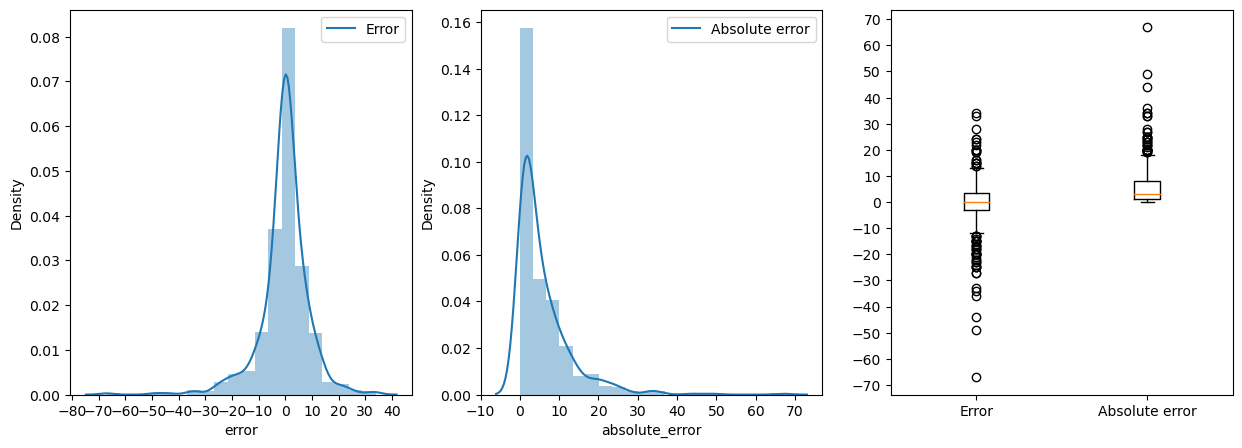

count    563.000000
mean      -0.309059
std        9.196184
min      -67.000000
25%       -3.000000
50%        0.000000
75%        3.500000
max       34.000000
Name: error, dtype: float64

 count    563.000000
mean       5.772647
std        7.161197
min        0.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       67.000000
Name: absolute_error, dtype: float64


,date,FilingsByMonth,tract,FilingsByMonth_prediction,error,absolute_error
64,2022-12-01,101.0,302.28,68,-33.0,33.0
127,2022-12-01,64.0,312.05,30,-34.0,34.0
226,2022-12-01,89.0,231.08,22,-67.0,67.0
268,2022-12-01,82.0,235.06,33,-49.0,49.0
315,2022-12-01,16.0,106.03,50,34.0,34.0
411,2022-12-01,65.0,73,29,-36.0,36.0
420,2022-12-01,30.0,77.06,63,33.0,33.0
511,2022-12-01,83.0,505.23,39,-44.0,44.0


In [105]:
df_error = result_analysis(df_result_1m)
df_error[df_error.absolute_error > 30]

In [106]:
def result_plot(df_res: pd.DataFrame):

  fig = plt.figure(figsize = (24, 8))

  # Create the scatter plot
  plt.subplot(1, 3, 1)
  plt.scatter(df_res.FilingsByMonth, df_res.FilingsByMonth_prediction)

  x = range(0, max(df_res.FilingsByMonth.astype(int)))
  plt.plot(x, x, color='red', label='Line')

  y_major_locator = plt.MultipleLocator(10)
  ax1 = plt.gca()
  ax1.yaxis.set_major_locator(y_major_locator)

  # Set labels for the axes
  plt.xlabel('Filings By Month')
  plt.ylabel('Prediction')

  # Create histogram
  plt.subplot(1, 3, 2)
  sns.distplot(df_res.FilingsByMonth, bins = 50)
  sns.distplot(df_res.FilingsByMonth_prediction, bins = 50)
  plt.legend(['Filings By Month', 'Prediction'])
  x_major_locator = plt.MultipleLocator(10)
  ax2 = plt.gca()
  ax2.xaxis.set_major_locator(x_major_locator)

  # Create boxplot
  plt.subplot(1, 3, 3)
  plt.boxplot([df_res.FilingsByMonth, df_res.FilingsByMonth_prediction], labels = ['Filings By Month', 'Prediction'])
  y_major_locator = plt.MultipleLocator(10)
  ax3 = plt.gca()
  ax3.yaxis.set_major_locator(y_major_locator)
  plt.show()

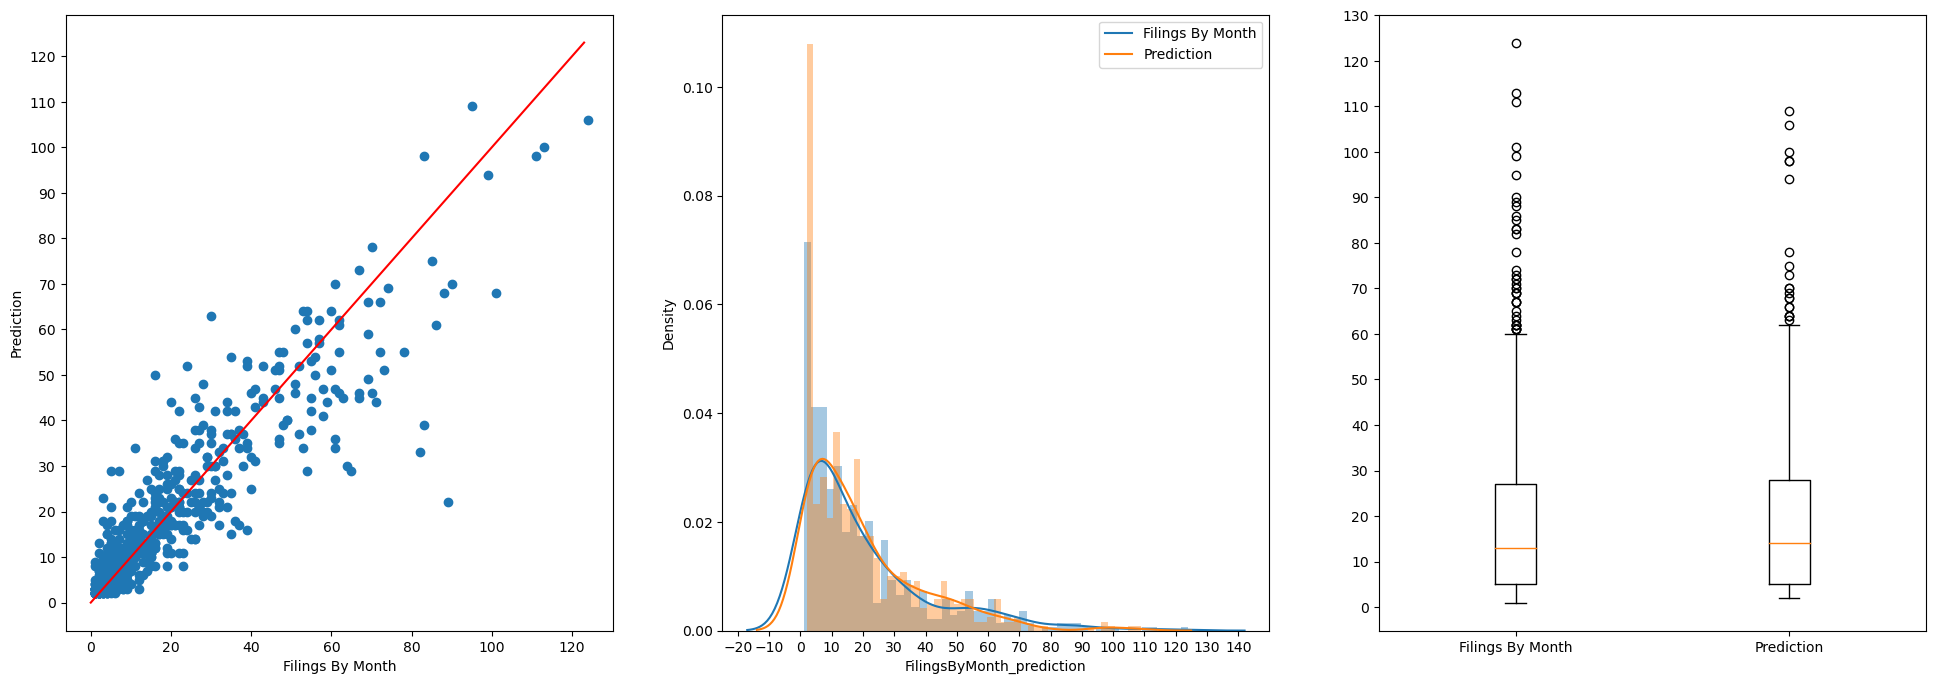

In [107]:
result_plot(df_result_1m)

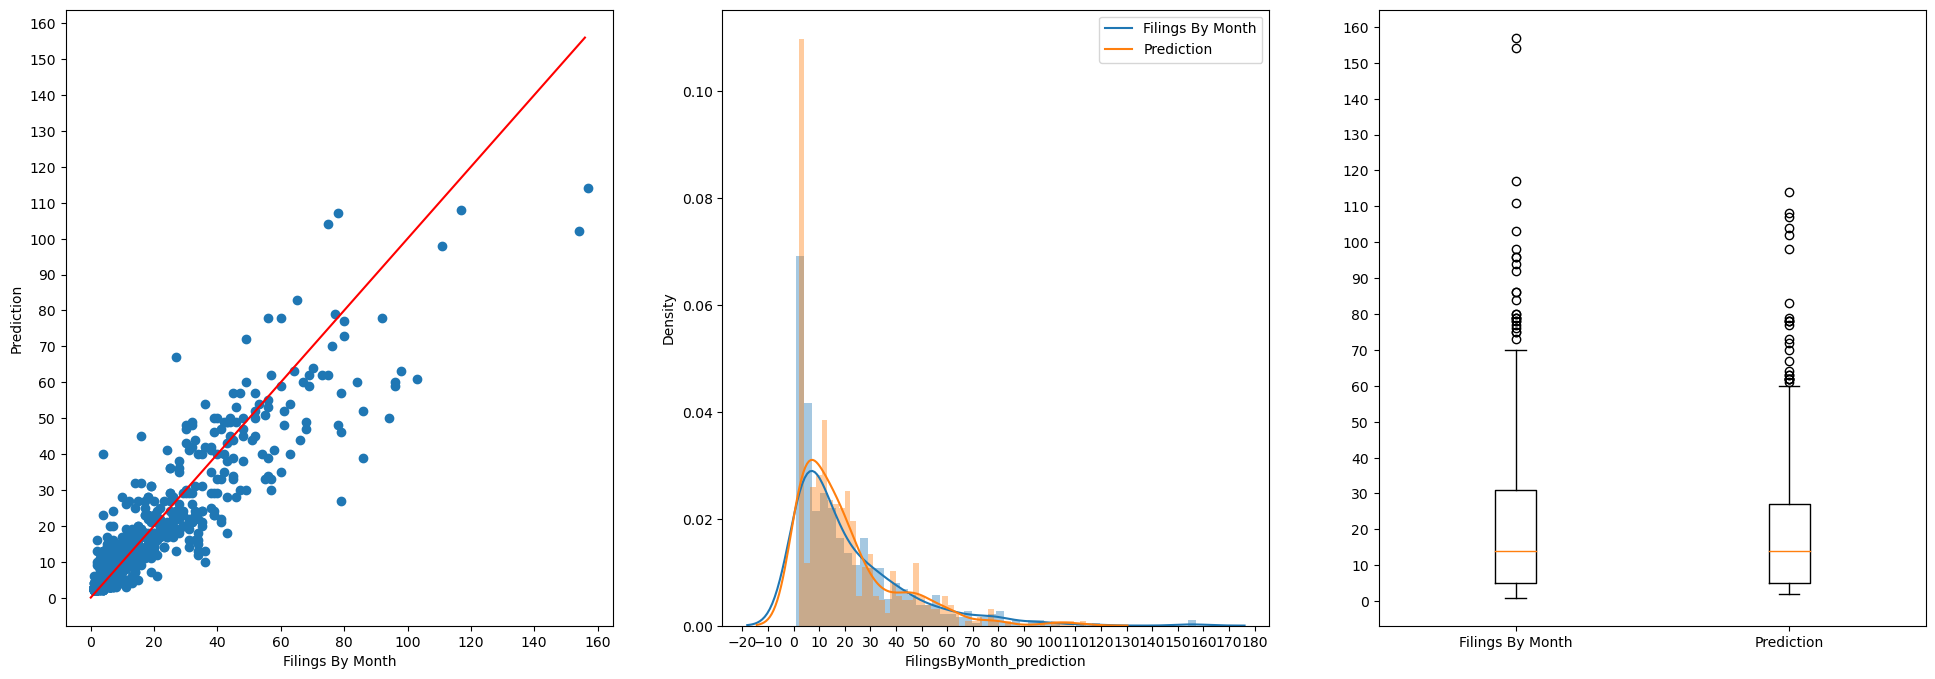

In [108]:
result_plot(df_result_3m)

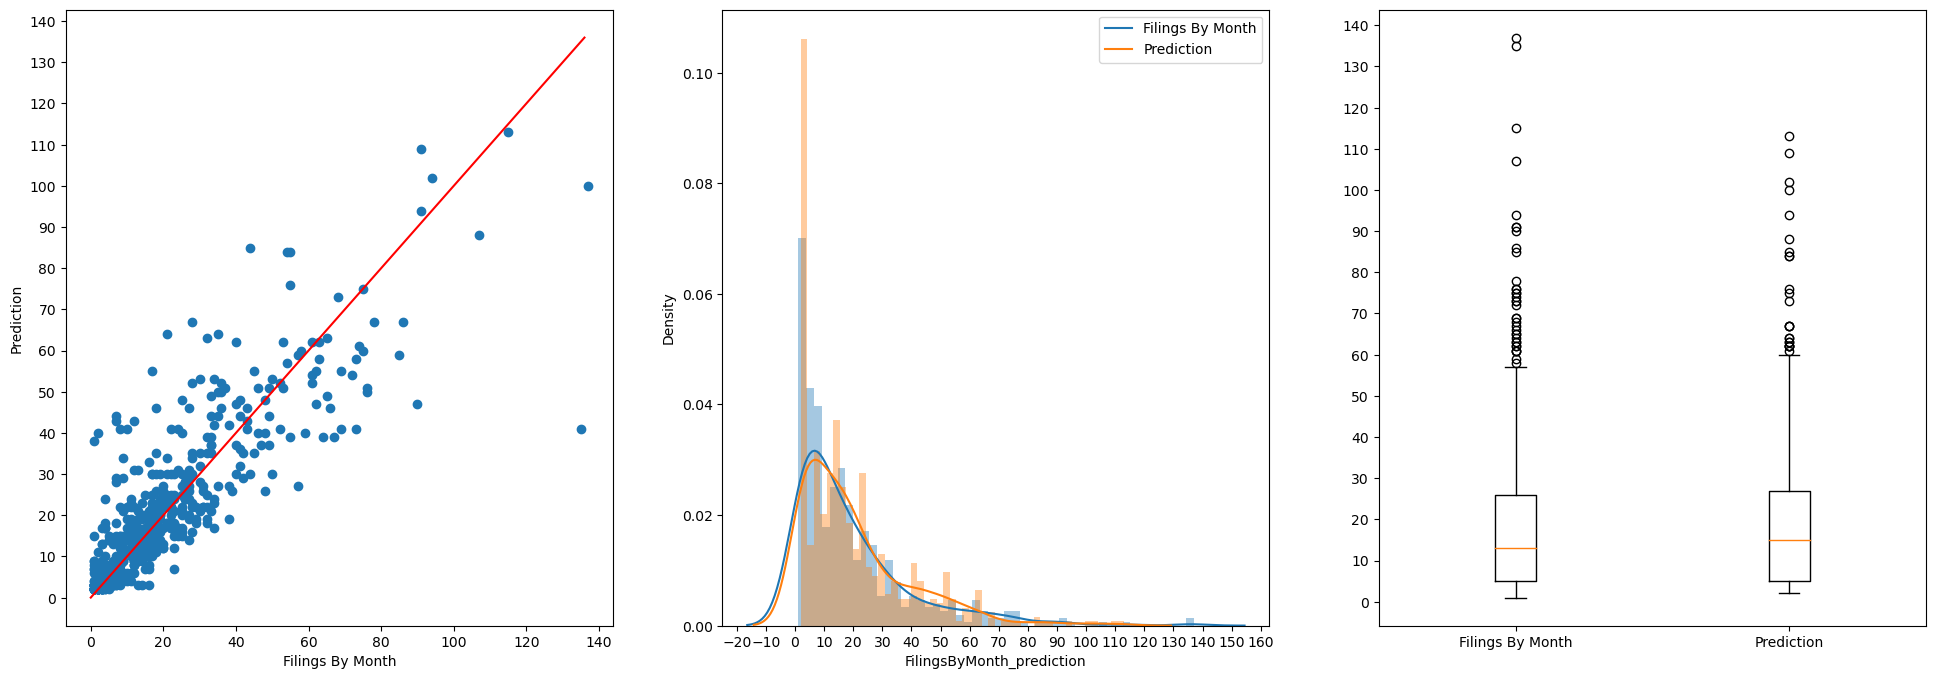

In [109]:
result_plot(df_result_6m)

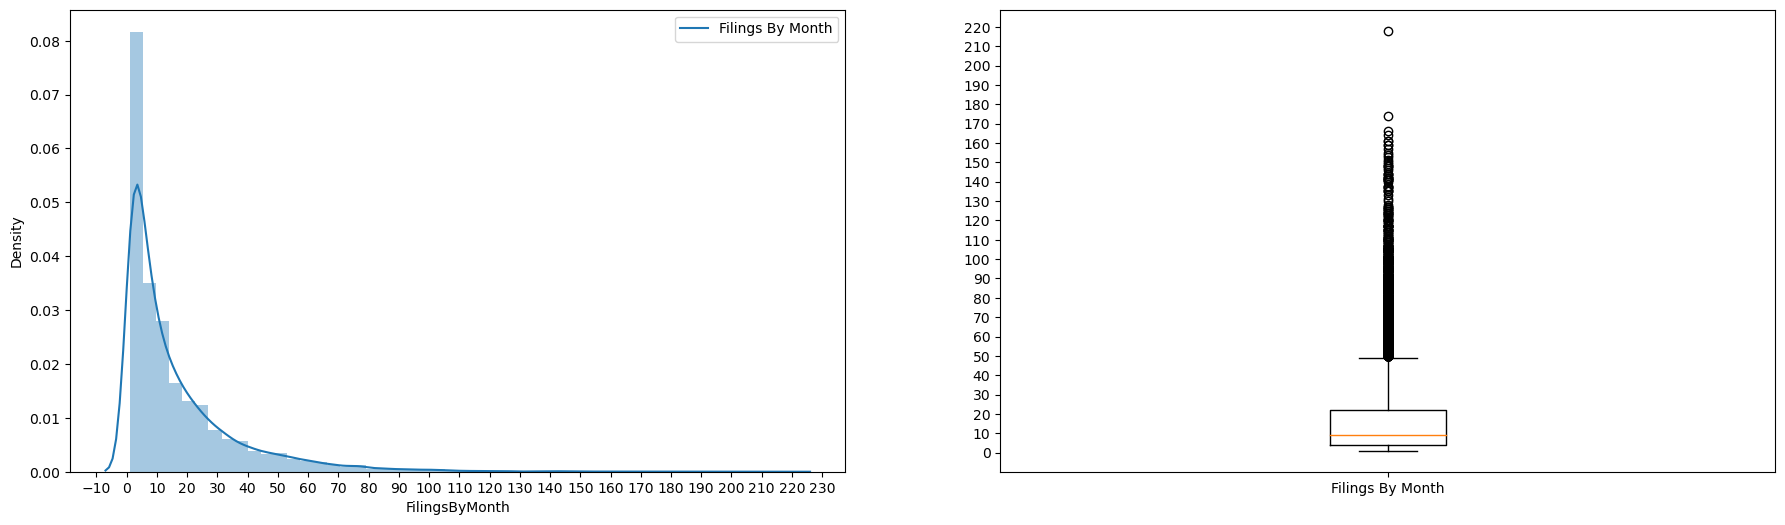

In [110]:
fig = plt.figure(figsize = (22, 6))

# Create histogram
plt.subplot(1, 2, 1)
sns.distplot(df.FilingsByMonth, bins = 50)
plt.legend(['Filings By Month'])
x_major_locator = plt.MultipleLocator(10)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(x_major_locator)

# Create boxplot
plt.subplot(1, 2, 2)
plt.boxplot([df.FilingsByMonth], labels = ['Filings By Month'])
y_major_locator = plt.MultipleLocator(10)
ax2 = plt.gca()
ax2.yaxis.set_major_locator(y_major_locator)
plt.show()

In [115]:
print(df.FilingsByMonth.describe())

count    22236.000000
mean        16.580050
std         19.696392
min          1.000000
25%          4.000000
50%          9.000000
75%         22.000000
max        218.000000
Name: FilingsByMonth, dtype: float64


### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

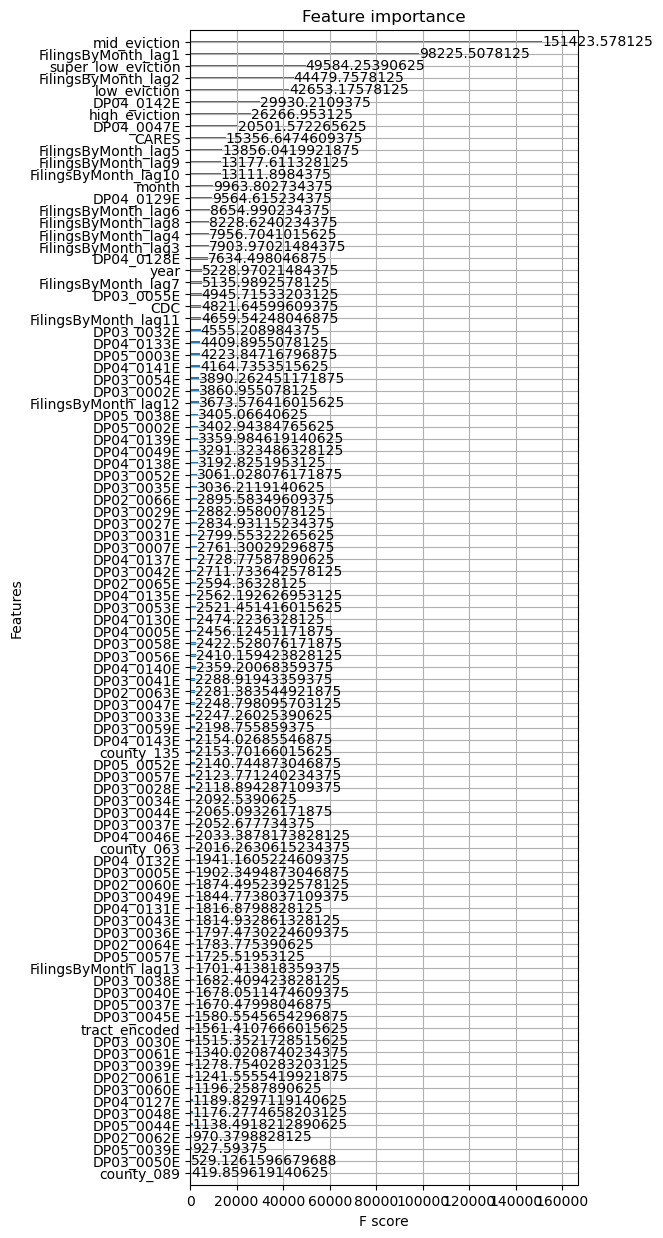

In [112]:
plt.rcParams['figure.figsize'] = (5, 15)
xgb.plot_importance(model_1m, importance_type='gain')

In [116]:
feature_importance = model_1m.get_booster().get_score(importance_type='gain')
feature_importance = pd.DataFrame({'feature': feature_importance.keys(
), 'importance': feature_importance.values()}).sort_values('importance', ascending=False)

feature_importance.reset_index(drop = True, inplace = True)
print(feature_importance)

                feature     importance
0          mid_eviction  151423.578125
1   FilingsByMonth_lag1   98225.507812
2    super_low_eviction   49584.253906
3   FilingsByMonth_lag2   44479.757812
4          low_eviction   42653.175781
..                  ...            ...
90           DP05_0044E    1138.491821
91           DP02_0062E     970.379883
92           DP05_0039E     927.593750
93           DP03_0050E     529.126160
94           county_089     419.859619

[95 rows x 2 columns]


In [117]:
print(feature_importance.feature.tolist())

['mid_eviction', 'FilingsByMonth_lag1', 'super_low_eviction', 'FilingsByMonth_lag2', 'low_eviction', 'DP04_0142E', 'high_eviction', 'DP04_0047E', 'CARES', 'FilingsByMonth_lag5', 'FilingsByMonth_lag9', 'FilingsByMonth_lag10', 'month', 'DP04_0129E', 'FilingsByMonth_lag6', 'FilingsByMonth_lag8', 'FilingsByMonth_lag4', 'FilingsByMonth_lag3', 'DP04_0128E', 'year', 'FilingsByMonth_lag7', 'DP03_0055E', 'CDC', 'FilingsByMonth_lag11', 'DP03_0032E', 'DP04_0133E', 'DP05_0003E', 'DP04_0141E', 'DP03_0054E', 'DP03_0002E', 'FilingsByMonth_lag12', 'DP05_0038E', 'DP05_0002E', 'DP04_0139E', 'DP04_0049E', 'DP04_0138E', 'DP03_0052E', 'DP03_0035E', 'DP02_0066E', 'DP03_0029E', 'DP03_0027E', 'DP03_0031E', 'DP03_0007E', 'DP04_0137E', 'DP03_0042E', 'DP02_0065E', 'DP04_0135E', 'DP03_0053E', 'DP04_0130E', 'DP04_0005E', 'DP03_0058E', 'DP03_0056E', 'DP04_0140E', 'DP03_0041E', 'DP02_0063E', 'DP03_0047E', 'DP03_0033E', 'DP03_0059E', 'DP04_0143E', 'county_135', 'DP05_0052E', 'DP03_0057E', 'DP03_0028E', 'DP03_0034E', 

### Tree Plot

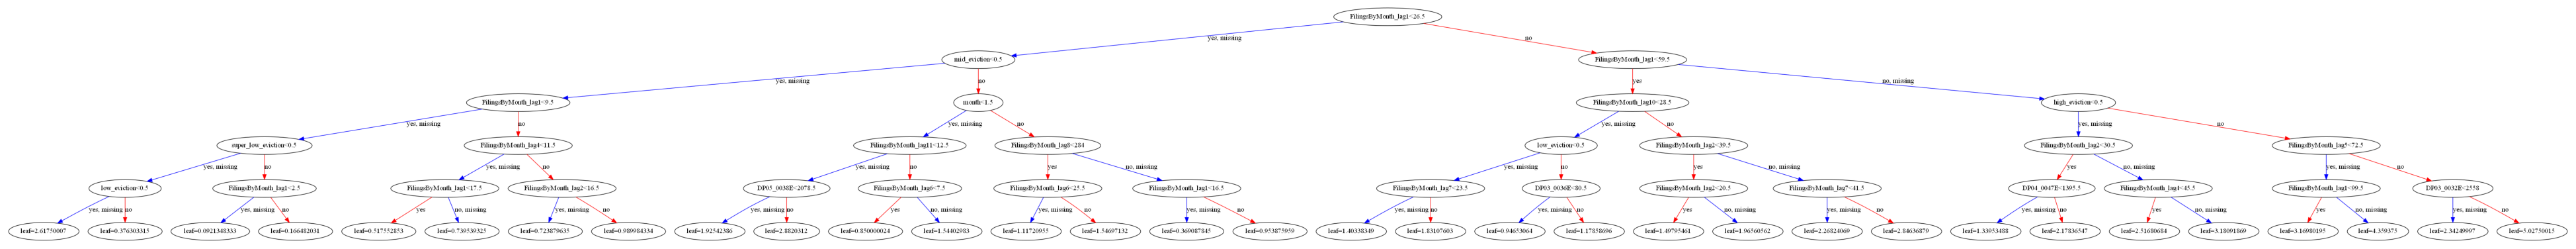

In [122]:
plt.figure(figsize=(50, 50))
xgb.plot_tree(model_1m, num_trees=0, ax=plt.gca())
plt.show()